In [3]:
import intervaltree

In [4]:
import numpy as np

In [13]:
import utils 
from collections import Counter

In [4]:
b = utils.get_page(0, b"Lohn.pdf")

In [5]:
arr = np.frombuffer(b, np.uint8)

In [23]:
img = arr.reshape(w,h,4)

In [7]:
w, h  = utils.get_page_size(0, b"Lohn.pdf")

In [8]:
w, h

(2479, 3504)

In [11]:
2479 * 3504 * 4

34745664

In [17]:
import matplotlib.pyplot as plt

In [3]:
from dataclasses import dataclass


@dataclass
class FlowItem:
    x: int
    y: int
    width: int
    height: int
    baseline: int
    linenumber: int

def get_baselines(new_lines):
    baselines = []
    for i in range(len(new_lines)):
        cnt = Counter([x[3] for x in new_lines[i]])
        l = len(cnt)
        commons = cnt.most_common(min(l, 3))
        mn = np.min([x for x, _ in commons])
        mx = np.max([x for x, _ in commons])
        baselines.append(int((mn + mx)/2))
    return baselines


In [4]:
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

In [13]:
from PIL import Image, ImageOps, ImageDraw
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import intervaltree
import cv2
import utils
from functools import reduce 

filename = "vd_p98.png"

def prepare_flow(filename):
    img = Image.open(filename)
    img_gray = img.convert("L")
    threshold = 100
    img_b = img_gray.point( lambda p: 255 if p > threshold else 0 )
    img_i = ImageOps.invert(img_b)
    structure = np.ones((3, 3), dtype=np.int8)
    ## label separate components 
    labeled, ncomponents = utils.label(img_i, structure)
    ll = defaultdict(list)
    nz = np.nonzero(labeled)
    ln = len(nz[0])
    
    for i in range(ln):
        a = nz[0][i]
        b = nz[1][i]
        ll[labeled[a][b]].append([a,b])
    
    rects = [] 
    
    for k in ll:
        c = np.array(ll[k])
        ymin = np.min(c[:,0])
        ymax = np.max(c[:,0])
        xmin = np.min(c[:,1])
        xmax = np.max(c[:,1])
        rects.append((xmin, xmax, ymin, ymax))
    
    w, h = img.size 
    d = defaultdict(list)
    for r in rects:
        d[(r[2], r[3])].append(r)
    tr = intervaltree.IntervalTree.from_tuples(d.keys())
    
    heights = np.array([x[3]-x[2] for x in rects])
    widths = np.array([x[1]-x[0] for x in rects])
    mean_h = np.mean(heights)
    mean_w = np.mean(widths)
    
    ints = []
    for i in range(h):
        ints.append(len(tr.at(i)))
    
    
    ys = utils.find_peaks(ints, distance=1.5*mean_h)[0]
    
    all_lines = []
    for y in ys:
        line = []
        for z in [d[(x.begin, x.end)] for x in tr.at(y)]:
            line.extend(z)
        all_lines.append(line)
    
    limits = []
    limits_set = set()
    for l in all_lines:
        lower = np.min([r[2] for r in l])
        upper = np.max([r[3]  for r in l])
        if not (lower, upper) in limits_set:
            limits.append((lower,upper))
            limits_set.add((lower,upper))
    
    new_lines = []
    for l in limits:
        intvs = tr.overlap(l[0], l[1])
        new_line = []
        for z in [d[(x.begin, x.end)] for x in intvs]:
            new_line.extend(z)
        new_lines.append(sorted(new_line, key=lambda x: x[0]))
    
    ### detect and correct low lines
    
    ratios = []
    max_value_args = []
    for line in new_lines:
        hs = [r[3]-r[2] for r in line]
        m = np.max(hs)
        max_value_args.append(np.argwhere(hs==m)[0][0])
        ratios.append(np.round(np.max(hs) / np.mean(hs), 1))
    
    
    common_ratio, _ = Counter(ratios).most_common(1)[0]
    to_correct_inds = [x[0] for x in np.argwhere(ratios < common_ratio)]
    
    for i, line in enumerate(new_lines):
        if i in to_correct_inds:
            x1,x2,y1,y2 = line[max_value_args[i]]
            r = ratios[i]
            coef = 1.1 * common_ratio / r
            line[max_value_args[i]] = (x1,x2, y2 - int(coef*(y2 - y1)) ,y2)
    
    ### end detecting
    
    new_limits = []
    for l in new_lines:
        new_lower = np.min([r[2] for r in l])
        new_upper = np.max([r[3]  for r in l])
        new_limits.append((new_lower,new_upper))
    
    v_limits = []
    for i, lim in enumerate(new_limits):  
        ymin, ymax = new_limits[i]
        line_b = img_i.crop((0, ymin, w, ymax)) 
        np_line = np.array(line_b)
        rv, rs, rl = find_runs(np.sum(np_line, axis=0))
        zero_inds = np.where(rv == 0)[0]
        A = rs[zero_inds]
        B = rs[zero_inds] + rl[zero_inds]
        C = []
        for element in zip(A, B):
            C.extend(element)
        v_limits.append(C)
    baselines = get_baselines(new_lines)
    
    flow_items = []
    left_spaces = []
    for i, l in enumerate(new_limits): 
        lower, upper = l
        height = upper  - lower 
        v_limit = v_limits[i]
        baseline = baselines[i]
        vlen = len(v_limit)
        for k, p in enumerate(zip(v_limit[:-1], v_limit[1:])):
            xmin , xmax = p
            width = xmax - xmin
            if k == 0:
                left_spaces.append(width)
            elif k != vlen-2:
                flow_items.append(FlowItem(xmin, lower, width, height, upper - baseline, i))
            else:
                flow_items.append(FlowItem(xmin, lower, int(0.5*mean_w), height, upper - baseline, i))
    
    common_left_space, count  = Counter([ls for ls in left_spaces]).most_common(1)[0]
    indents = dict()
    for i, s in enumerate(left_spaces):
        if abs(s - common_left_space) > 5*mean_w:
            indents[i] =  2
        elif abs(s - common_left_space) > 0.3*mean_w:
            indents[i] =  1
        else:
            indents[i] = 0

    return img, int(5*mean_w), flow_items, w, mean_h, indents


img, indent_width, flow_items, w, mean_h, indents = prepare_flow(filename)
indent_width

        
    
    
    
        
    
    




173

In [11]:
def flow_step(new_w, indent_width, indents, state):
    indents_processed = dict()
    def inner_flow_step(a,b):
        w, d, line_counter, i, fi, d_indents = state
        if indents[b.linenumber] > 0 and not indents_processed.get(b.linenumber, False):
            line_counter += 1
            state[2] = line_counter
            d[line_counter].append(b)
            d_indents[line_counter] = True
            indents_processed[b.linenumber] = True
            state[0] = 2*indent_width + b.width
        else:
            if w+b.width <= (new_w - indent_width):
                d[line_counter].append(b)
                state[0] += b.width
                if indents[b.linenumber] == 2:
                    if i<len(fi)-2:
                        next_item = fi[i+2]
                        #print(b, next_item)
                        if next_item.linenumber > b.linenumber:
                            line_counter += 1
                            state[2] = line_counter
                            state[0] = 2*indent_width
                            d_indents[line_counter] = True
                            indents_processed[next_item.linenumber] = True 
            else:
                line_counter += 1
                state[2] = line_counter
                d[line_counter].append(b)
                state[0] = indent_width + b.width
            

        state[3] += 1
            
    return inner_flow_step

        

In [297]:
def f(_, a):
    print(a)

In [299]:
f(1,2)

2


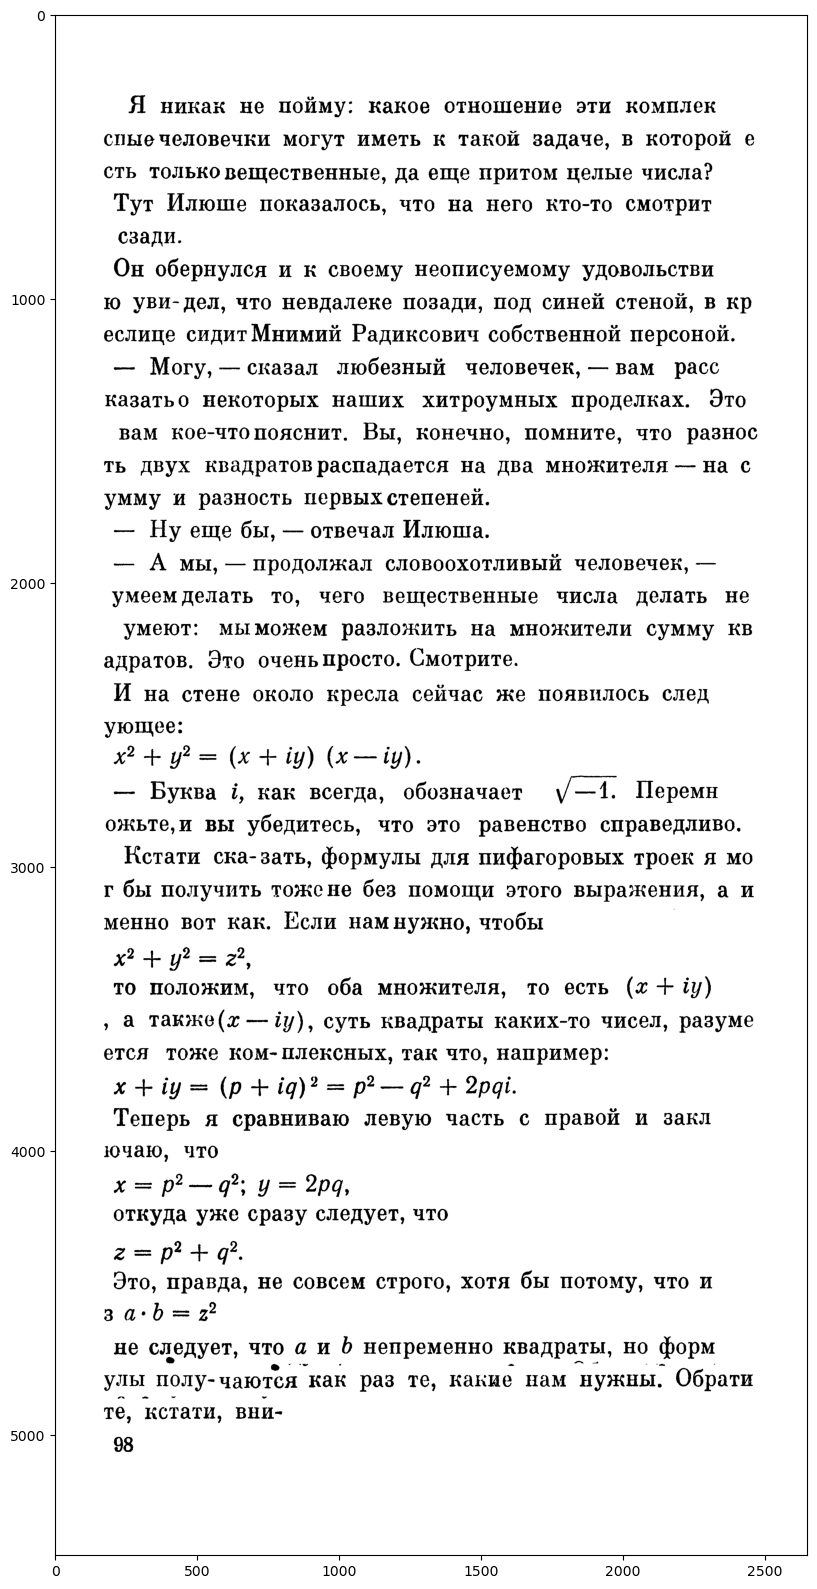

In [14]:
from functools import reduce 


def reflow(indent_width, flow_items):
    new_w = int(0.8 * w)
    state = [indent_width, defaultdict(list), 0, 0, flow_items, dict()]
    reduce(flow_step(new_w, indent_width, indents, state), flow_items)
    new_h = int((state[2] * 3  + 15) * mean_h)
    line_count = state[2]
    reflowed_lines = state[1]
    d_indents = state[5]
    newimage = Image.new(mode='RGB', size=(new_w, new_h), color='white')
    
    y = int(3 * mean_h)
    line_h = int(3*mean_h)
    x = indent_width
    
    for l in range(line_count+1):
        reflowed_line = reflowed_lines[l]
        for k, s in enumerate(reflowed_line):
            if k == 0 and d_indents.get(l, False):
                x += int(0.2*indent_width)
                
            letter_img = img.crop((s.x, s.y, s.x + s.width, s.y + s.height))
            newimage.paste(letter_img, (x, y + line_h + s.baseline - s.height))
            x += s.width
        x = indent_width
        if l < line_count:
            line_to_check = reflowed_lines[l+1]
            max_height = np.max([x.height for x in line_to_check])
            
        y += int(3 * mean_h) if 3*mean_h > max_height else int(max_height)
    return newimage

    
newimage =  reflow(indent_width, flow_items)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(np.asarray(newimage))


In [225]:

reflowed_lines[18]

[FlowItem(x=2632, y=1982, width=35, height=77, baseline=16, linenumber=16),
 FlowItem(x=2667, y=1982, width=6, height=77, baseline=16, linenumber=16),
 FlowItem(x=2673, y=1982, width=32, height=77, baseline=16, linenumber=16),
 FlowItem(x=2705, y=1982, width=5, height=77, baseline=16, linenumber=16),
 FlowItem(x=2710, y=1982, width=36, height=77, baseline=16, linenumber=16),
 FlowItem(x=2746, y=1982, width=50, height=77, baseline=16, linenumber=16),
 FlowItem(x=2796, y=1982, width=40, height=77, baseline=16, linenumber=16),
 FlowItem(x=2836, y=1982, width=6, height=77, baseline=16, linenumber=16),
 FlowItem(x=2842, y=1982, width=36, height=77, baseline=16, linenumber=16),
 FlowItem(x=2878, y=1982, width=6, height=77, baseline=16, linenumber=16),
 FlowItem(x=2884, y=1982, width=24, height=77, baseline=16, linenumber=16),
 FlowItem(x=2908, y=1982, width=17, height=77, baseline=16, linenumber=16),
 FlowItem(x=404, y=2069, width=36, height=81, baseline=18, linenumber=17),
 FlowItem(x=440, 

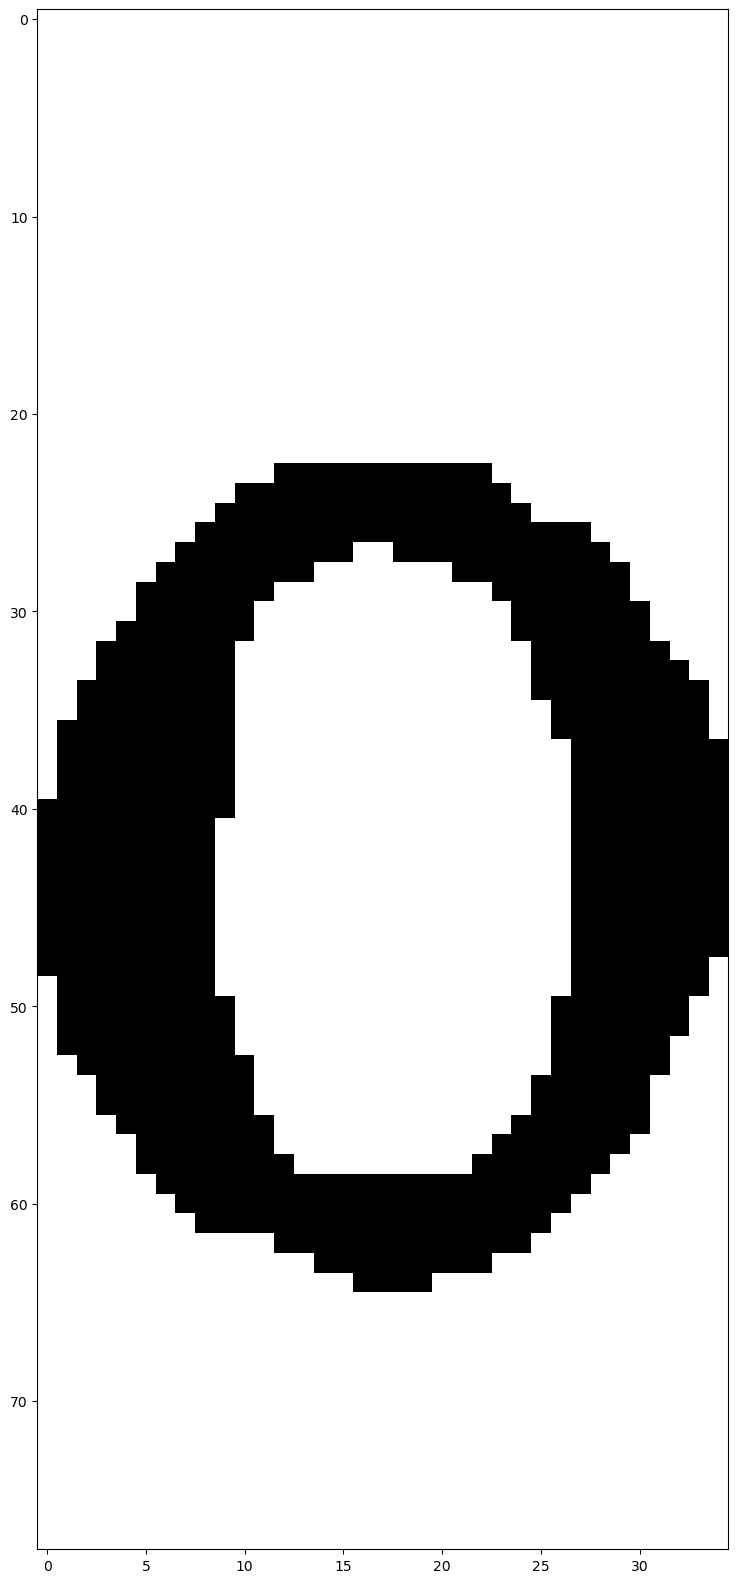

In [112]:
o = img.crop((2464,318,2464+35, 318+78))
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(np.asarray(o))

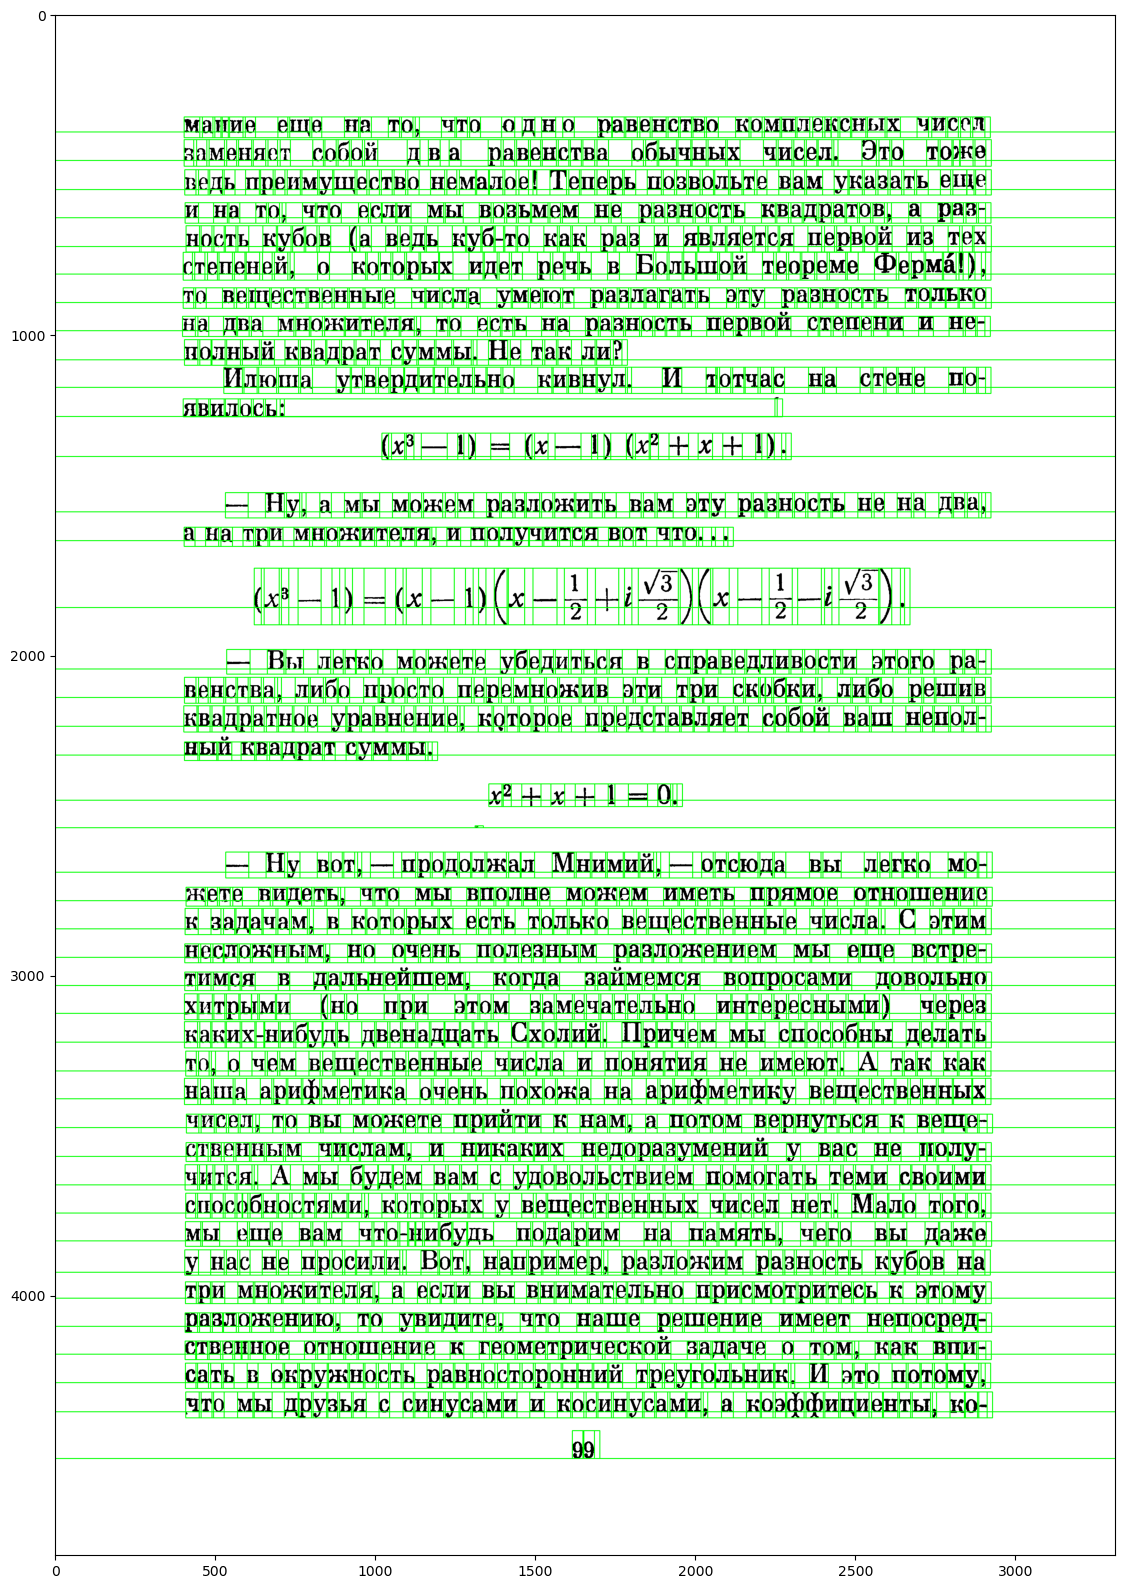

In [267]:
filename = "../../vd_p99.png"
img = cv2.imread(filename)
for fl in flow_items:
    cv2.rectangle(img,(fl.x,fl.y),(fl.x + fl.width,fl.y + fl.height),(0,255,0),2)

for b in baselines:
    cv2.line(img,(0,b),(3312,b),(0,255,0),2)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img)
    

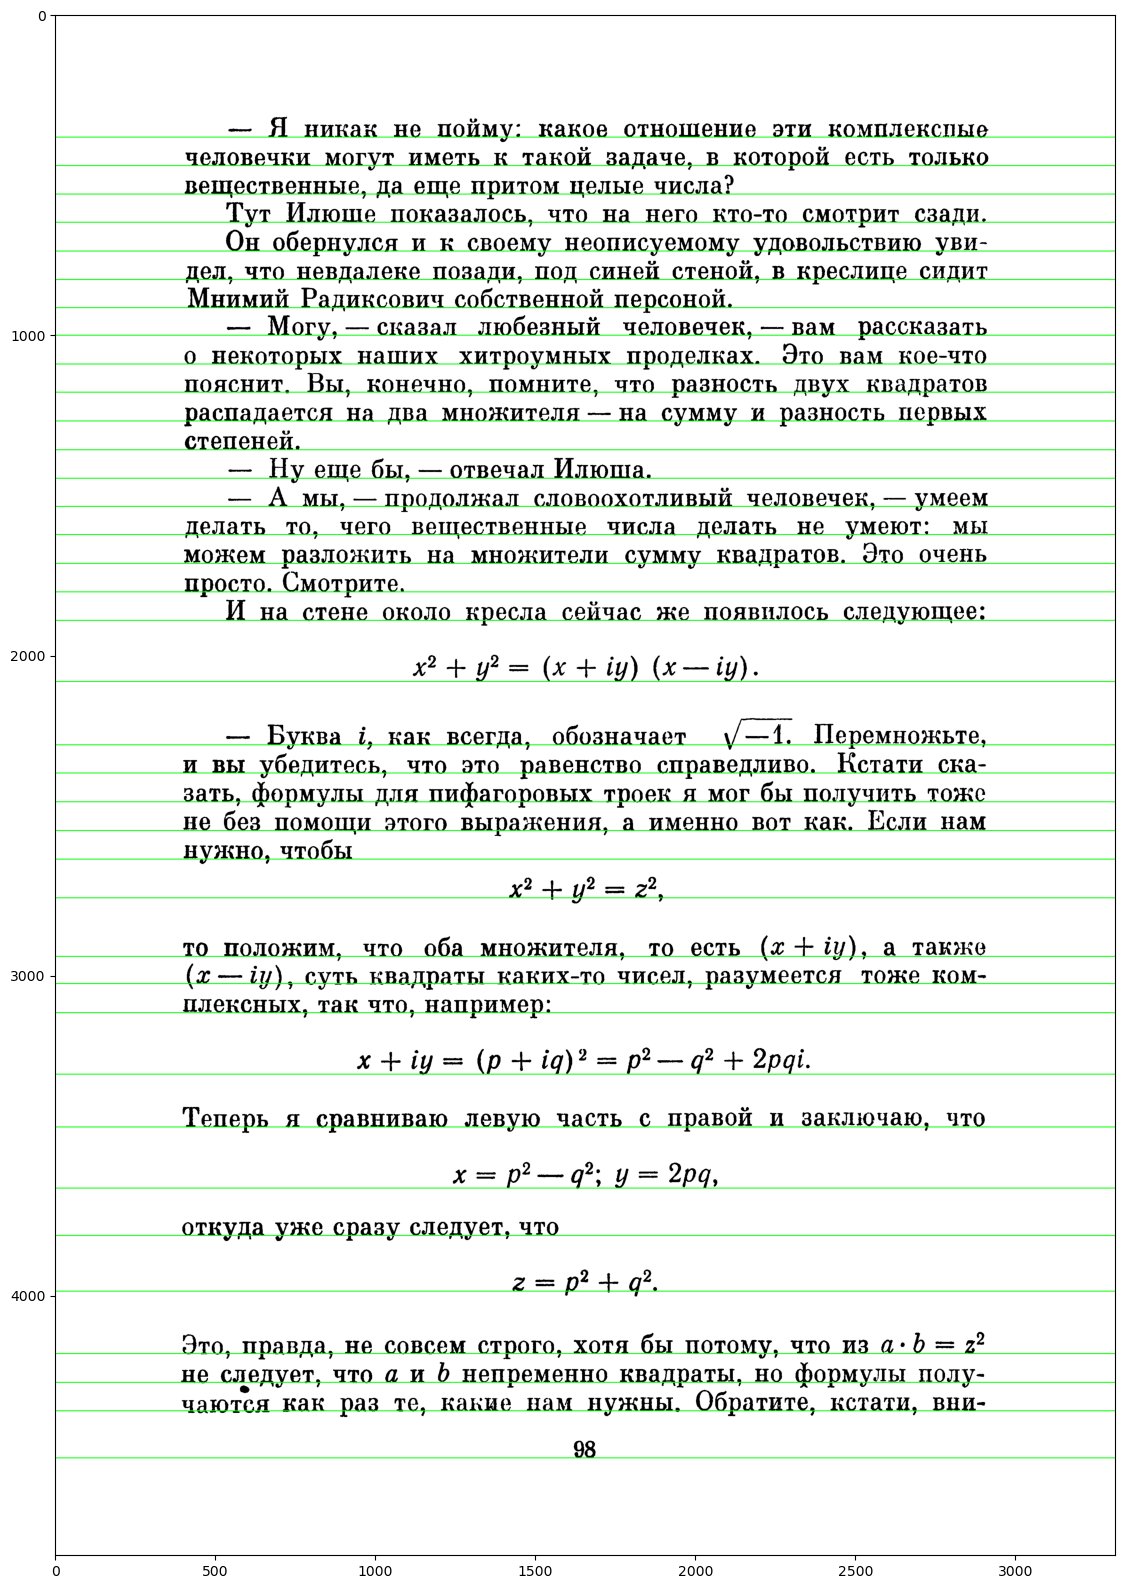

In [25]:
filename = "../../vd_p98.png"
img = cv2.imread(filename)
img.shape
for b in baselines:
    cv2.line(img,(0,b),(3312,b),(0,255,0),2)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img)

In [14]:
filename = "../../vd_p98.png"
img = cv2.imread(filename)
img.shape

(4812, 3312, 3)

In [53]:
ratios = []
max_value_args = []
for line in new_lines:
    hs = [r[3]-r[2] for r in line]
    m = np.max(hs)
    max_value_args.append(np.argwhere(hs==m)[0][0])
    ratios.append(np.round(np.max(hs) / np.mean(hs), 1))



common_ratio, _ = Counter(ratios).most_common(1)[0]
to_correct_inds = [x[0] for x in np.argwhere(ratios < common_ratio)]




[1, 2, 5, 10, 11, 23, 29, 31, 36]

In [55]:
common_ratio, _ = Counter(ratios).most_common(1)[0]
to_correct_inds = [x[0] for x in np.argwhere(ratios < common_ratio)]

In [58]:
for i, line in enumerate(new_lines):
    if i in to_correct_inds:
        x1,x2,y1,y2 = line[max_value_args[i]]
        line[max_value_args[i]] = (x1,x2, y2 - int(common_ratio*(y2 - y1)) ,y2)
        


(2291, 2329, 427, 485)
(1350, 1390, 517, 575)
(2367, 2405, 784, 841)
(404, 444, 1226, 1285)
(406, 441, 1315, 1358)
(832, 867, 2575, 2637)
(399, 451, 3412, 3474)
(524, 567, 3772, 3830)
(1655, 1688, 4455, 4508)


In [201]:
indents = dict()
for i, s in enumerate(left_spaces):
    if abs(s - common_left_space) > 5*mean_w:
        indents[i] =  2
    elif abs(s - common_left_space) > 0.3*mean_w:
        indents[i] =  1
    else:
        indents[i] = 0

In [ ]:
j

In [15]:
w, h = img.size 
d = defaultdict(list)
for r in rects:
    d[(r[2], r[3])].append(r)
tr = intervaltree.IntervalTree.from_tuples(d.keys())

heights = np.array([x[3]-x[2] for x in rects])
mean_h = np.mean(heights)

ints = []
for i in range(h):
    ints.append(len(tr.at(i)))


ys = utils.find_peaks(ints, distance=1.5*mean_h)[0]

all_lines = []
for y in ys:
    line = []
    for z in [d[(x.begin, x.end)] for x in tr.at(y)]:
        line.extend(z)
    all_lines.append(line)

limits = []
for l in all_lines:
    lower = np.min([r[2] for r in l])
    upper = np.max([r[3]  for r in l])
    limits.append((lower,upper))

new_lines = []
for l in limits:
    intvs = tr.overlap(l[0], l[1])
    new_line = []
    for z in [d[(x.begin, x.end)] for x in intvs]:
        new_line.extend(z)
    new_lines.append(sorted(new_line, key=lambda x: x[0]))

new_limits = []
for l in new_lines:
    new_lower = np.min([r[2] for r in l])
    new_upper = np.max([r[3]  for r in l])
    new_limits.append((new_lower,new_upper))

for i, lim in new_limits:  
    ymin, ymax = new_limits[i]
    line_b = img_i.crop((0, ymin, w, ymax)) 
    np_line = np.array(line_b)
    rv, rs, rl = find_runs(np.sum(np_line, axis=0))
    zero_inds = np.where(rv == 0)[0]
    A = rs[zero_inds]
    B = rs[zero_inds] + rl[zero_inds]
    C = []
    for element in zip(A, B):
        C.extend(element)
    baselines = get_baselines(new_lines)
        
    
    
    


In [153]:
def get_baselines(new_lines):
    baselines = []
    for i in range(len(new_lines)):
        y, _  = Counter([x[3] for x in new_lines[i]]).most_common(1)[0]
        baselines.append(y)
    return baselines

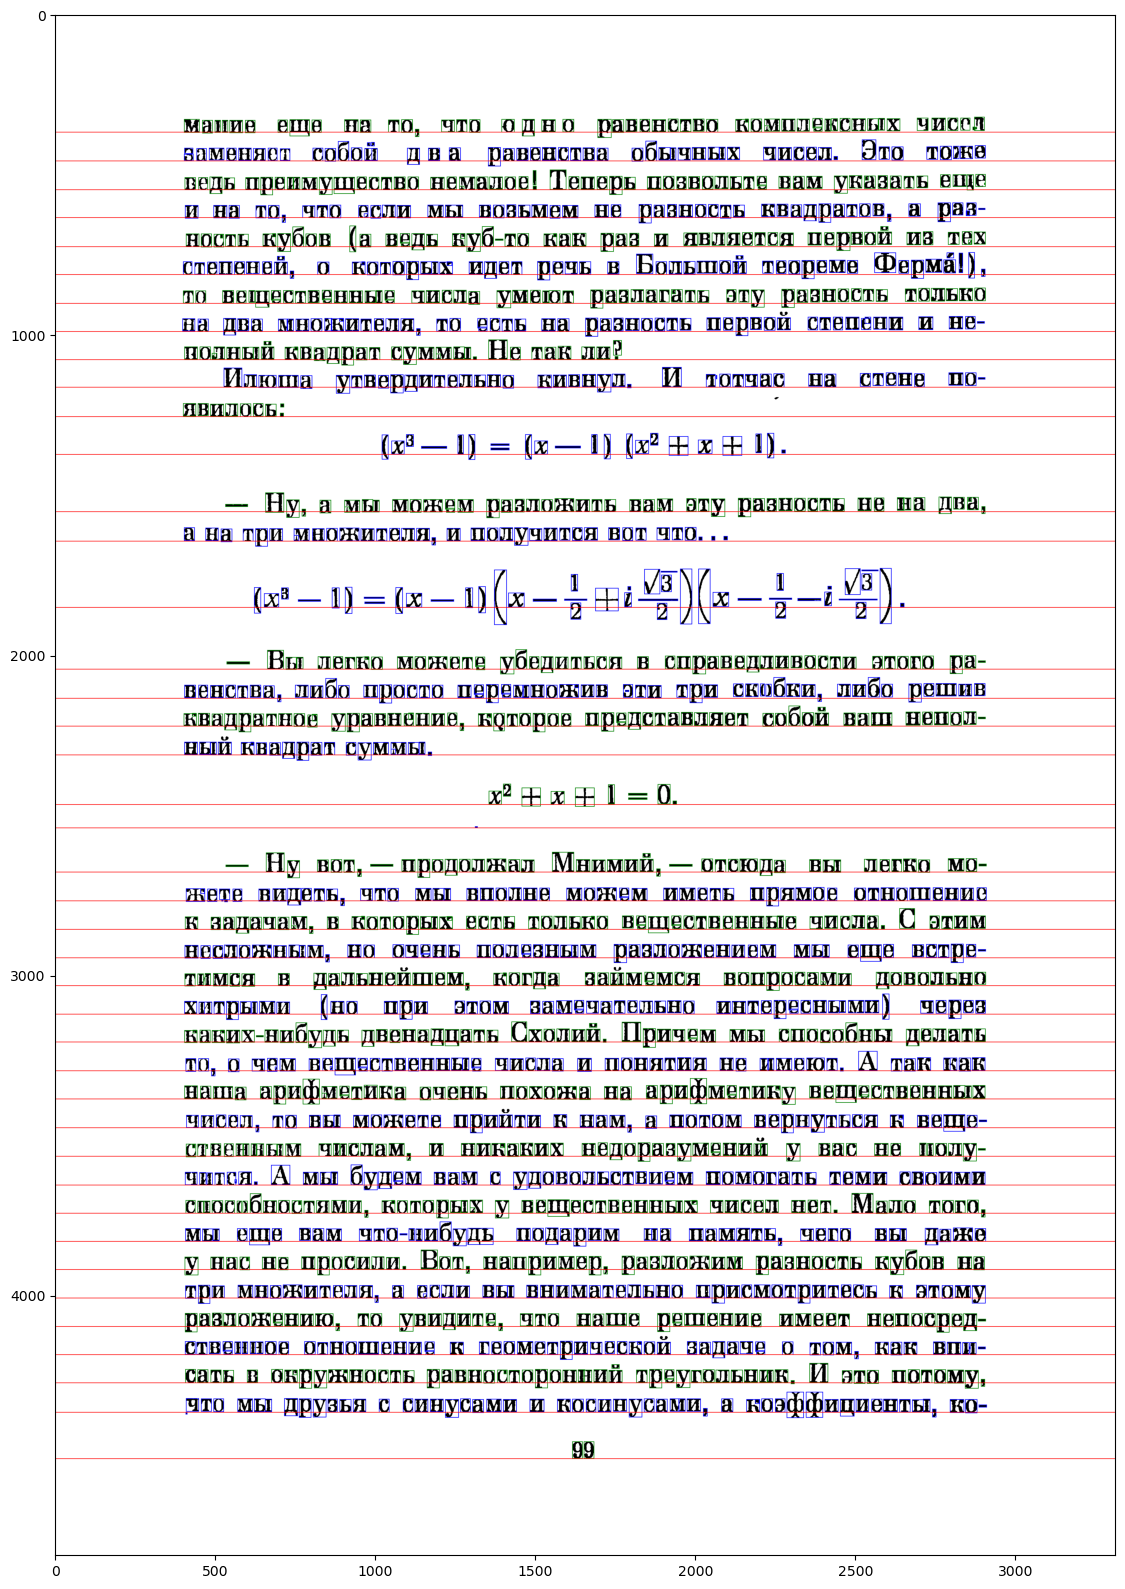

In [152]:
img1 = Image.open(filename)
draw1 = ImageDraw.Draw(img1)

counter = 0
for i, l in enumerate(new_lines):
    for r in l:
        color = "green" if counter % 2 == 0 else "blue"
        draw1.polygon([(r[0],r[2]), (r[1],r[2]), (r[1],r[3]), (r[0],r[3])], fill=None, outline=color, width=2)
        draw1.line([(0,baselines[i]), (w, baselines[i])], fill="red", width=2)
    counter += 1

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img1)

In [19]:
new_limits = []
for l in new_lines:
    new_lower = np.min([r[2] for r in l])
    new_upper = np.max([r[3]  for r in l])
    new_limits.append((new_lower,new_upper))

In [147]:
baselines

[4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324,
 4324]

In [93]:
ymin, ymax = new_limits[1]
line = img1.crop((0, ymin, w, ymax))
line_g = line.convert("L")
threshold = 100
line_b = line_g.point( lambda p: 255 if p > threshold else 0 )
##plt.rcParams['figure.figsize'] = [20, 20]
##plt.imshow(line_b)

line_b = ImageOps.invert(line_b)

np_line = np.array(line_b)
##plt.plot(np.sum(np_line, axis=0))
np.nonzero(np.sum(np_line, axis=0))


(array([ 403,  404,  405, ..., 2905, 2906, 2907]),)

In [94]:
rv, rs, rl = find_runs(np.sum(np_line, axis=0))

In [95]:
zero_inds = np.where(rv == 0)[0]

In [96]:
A = rs[zero_inds]

In [97]:
B = rs[zero_inds] + rl[zero_inds]

In [98]:
C = []
for element in zip(A, B):
    C.extend(element)

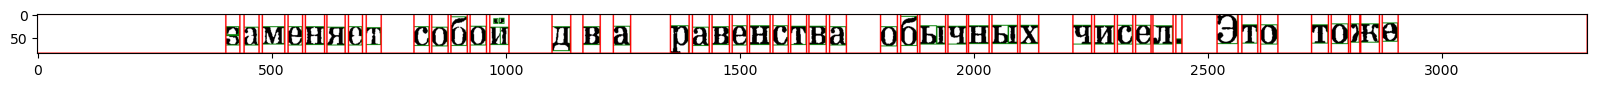

In [99]:
draw2 = ImageDraw.Draw(line)

h = ymax - ymin 
for i in range(len(C)-1):
    x1 = C[i]
    x2 = C[i+1]
    y1 = 0 
    y2 = h
    draw2.polygon([(x1,y1), (x2,y1), (x2,y2), (x1,y2)], fill=None, outline="red", width=2)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(line)    
    

In [123]:
from collections import Counter

In [150]:
def get_baselines(new_lines):
    baselines = []
    for i in range(len(new_lines)):
        y, _  = Counter([x[3] for x in new_lines[i]]).most_common(1)[0]
        baselines.append(y)
    return baselines


In [151]:
baselines = get_baselines(new_lines)

In [29]:
indices = np.indices(img_i.size).T[:,:,[1, 0]]

In [45]:
indices[labeled == 12]

array([[ 323, 2602],
       [ 323, 2614],
       [ 323, 2615],
       ...,
       [ 362, 2637],
       [ 362, 2638],
       [ 362, 2639]])

In [49]:
ymin = np.min(indices[labeled == 12][:,0])
ymax = np.max(indices[labeled == 12][:,0])
xmin = np.min(indices[labeled == 12][:,1])
xmax = np.max(indices[labeled == 12][:,1])

In [90]:
labeled

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [70]:
comps = []
for i in range(ncomponents):
    c = indices[labeled == i]
    #ymin = np.min(c[:,0])
    #ymax = np.max(c[:,0])
    #xmin = np.min(c[:,1])
    #xmax = np.max(c[:,1])
    comps.append(c)
    
    
    

In [91]:
from collections import defaultdict

In [124]:
nz = np.nonzero(labeled)
ln = len(nz[0])
segs = defaultdict(list)
a = nz[0][0]
b = nz[1][0]
labeled[a][b]

1

In [136]:
ll = defaultdict(list)
nz = np.nonzero(labeled)
ln = len(nz[0])
segs = defaultdict(list)
for i in range(ln):
    a = nz[0][i]
    b = nz[1][i]
    ll[labeled[a][b]].append([a,b])

rects = [] 

for k in ll:
    c = np.array(ll[k])
    ymin = np.min(c[:,0])
    ymax = np.max(c[:,0])
    xmin = np.min(c[:,1])
    xmax = np.max(c[:,1])
    rects.append((xmin, xmax, ymin, ymax))
    
    

In [137]:
len(rects)

1954

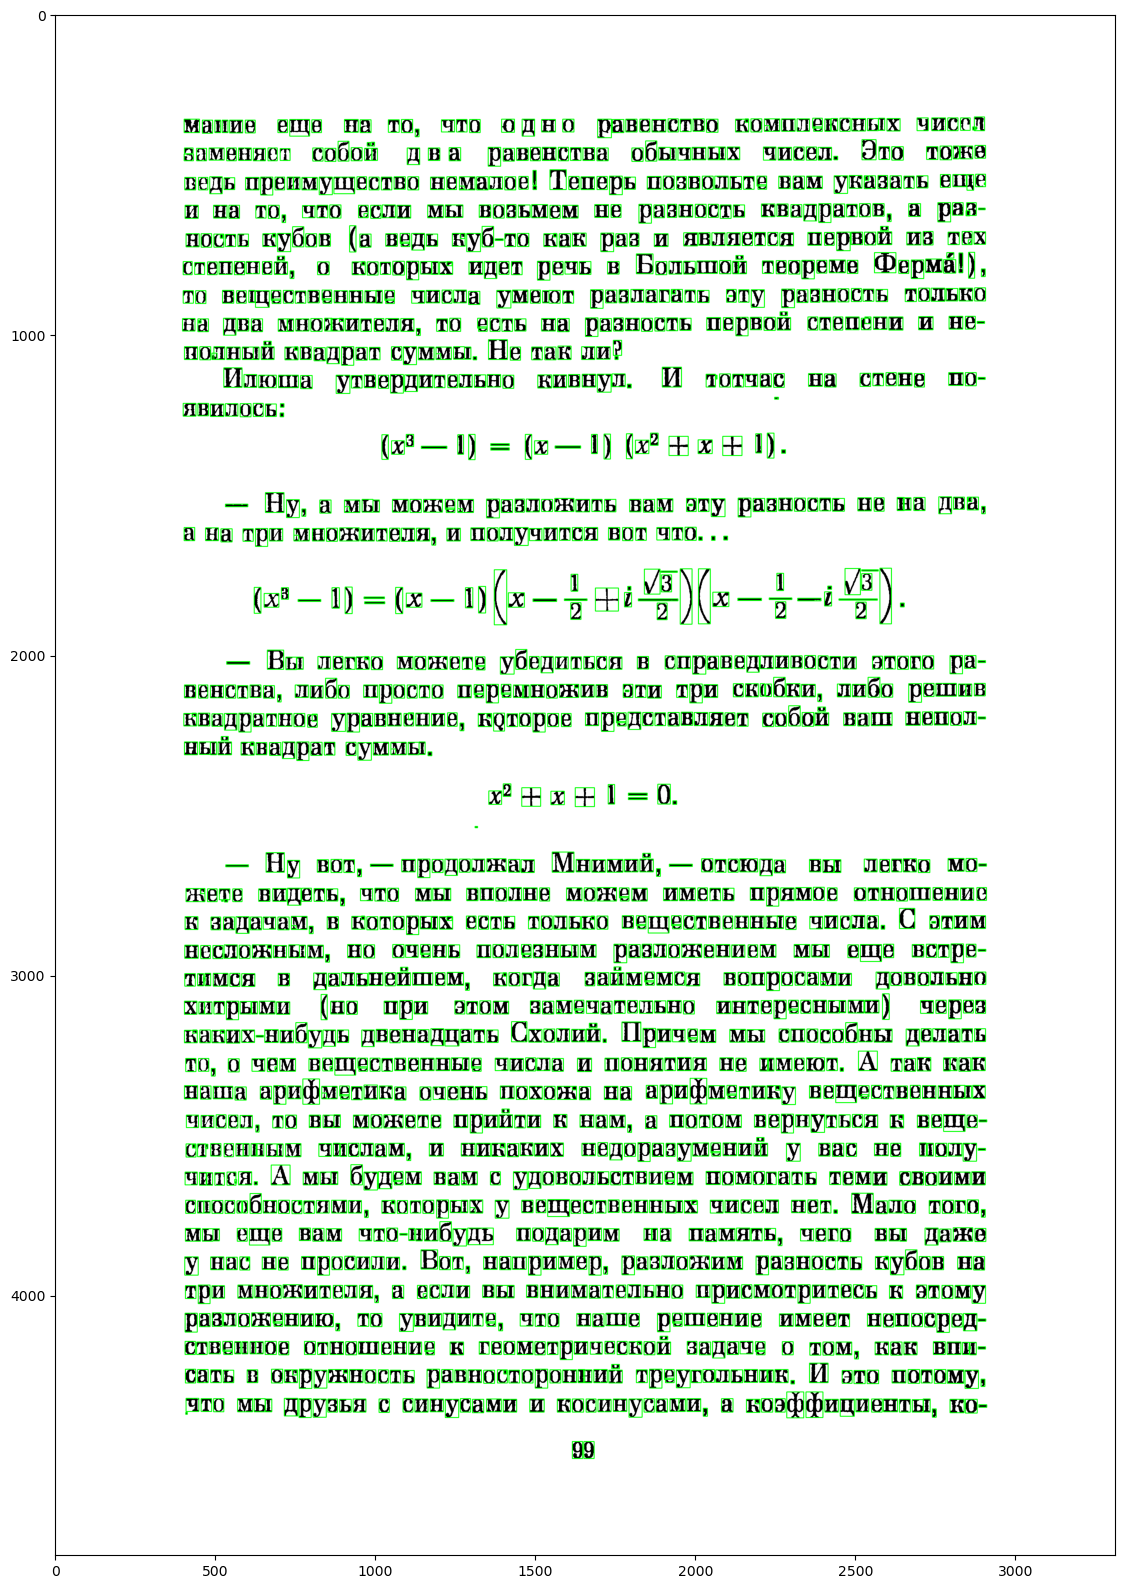

In [138]:
import matplotlib.pyplot as plt
import cv2

def segment_image(filename, rects):
    orig = cv2.imread(filename)
    for i, r in enumerate(rects):
        cv2.rectangle(orig,(r[1],r[3]),(r[0],r[2]),(0,255,0),2)

    return orig
    
filename = "../../vd_p99.png"

img = segment_image(filename, rects)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [150]:
import re

In [153]:
re.findall(r"\w*", "123errtt fdsdf")

['123errtt', '', 'fdsdf', '']

In [155]:
100 - (8 + 47.3 + 21.2)

23.5